## Imports

In [1]:
# ECT
import demeter.euler as euler
import demeter.directions as dirs
import demeter.misc as mis

In [2]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
import numpy as np

from gtda.plotting import plot_heatmap
from gtda.images import Binarizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import accuracy_score, adjusted_rand_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm
from joblib import Parallel, delayed

In [3]:
# logs file
import logging

logger = logging.getLogger()
if (logger.hasHandlers()):
    logger.handlers.clear()

# Configure logging to write to a file
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='ect_on_MNIST.log',
    filemode='a' # 'a' for append, 'w' for overwrite each run
)

logging.info("="*50)
logging.info("NEW TRAINING RUN STARTED")
logging.info("="*50)

In [4]:
# Load Data
transform = transforms.Compose([
    transforms.ToTensor(),              # convert to tensor [0,1]
    transforms.Normalize((0.5,), (0.5,)) # normalize to [-1,1]
])

MNIST_train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
MNIST_test_data = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)

MNIST_train_loader = DataLoader(MNIST_train_data, 128, True)
MNIST_test_loader = DataLoader(MNIST_test_data, 1000, True)

In [5]:
def plot_cell(img, binary_threshold, row_idx, col_idx, num_rows, num_cols, 
               row_label=None, title=None):
    """Helper to handle subplot creation and plotting."""
    bin_img = (img > binary_threshold).astype(int)
    plot_idx = row_idx * num_cols + col_idx + 1
    ax = plt.subplot(num_rows, num_cols, plot_idx)
    plt.imshow(bin_img, cmap='gray')
    plt.axis('off')
    
    if col_idx == 0 and row_label is not None:
        y_pos = bin_img.shape[0] / 2 if isinstance(row_label, str) else 14
        ax.text(-5, y_pos, str(row_label), va='center', ha='right', fontsize=8)
        
    if row_idx == 0 and title is not None:
        ax.set_title(title)

def get_adaptive_thresholds(img, quantiles):
    """Helper to calculate thresholds based on image distribution."""
    non_zero = img[img > 0.01]
    if non_zero.size == 0:
        return [0.0] * len(quantiles)
    return np.quantile(non_zero, quantiles)

def process_patches(img, patches, patch_q, start_row, col_idx, num_rows, num_cols, mode='quantile'):
    """
    Helper to loop through and plot patches.
    mode: 'quantile' (calculates quantile of patch) or 'fixed' (uses patch_q directly)
    """
    current_row = start_row
    for name, slice_obj in patches.items():
        patch_img = img[slice_obj]
        
        if mode == 'quantile':
            # Calculate adaptive threshold for the specific patch
            patch_non_zero = patch_img[patch_img > 0.01]
            if patch_non_zero.size == 0:
                t = 0.0
            else:
                t = np.quantile(patch_non_zero, patch_q)
        else:
            # Use fixed threshold
            t = patch_q
            
        plot_cell(patch_img, t, current_row, col_idx, num_rows, num_cols, row_label=name)
        current_row += 1

In [6]:
def plot_binarized_by_quantile(data, quantiles, target_label=0, num_images=10, patches=None, patch_q=0.7):
    num_patch_rows = len(patches) if patches else 0
    num_rows = len(quantiles) + num_patch_rows
    
    plt.figure(figsize=(num_images, num_rows + 1))
    
    count = 0
    for img_tensor, label in data:
        if label != target_label: continue
            
        img = img_tensor.numpy().squeeze()
        
        # 1. Get Thresholds
        thresholds = get_adaptive_thresholds(img, quantiles)

        # 2. Plot Main Rows
        for row_idx, t in enumerate(thresholds):
            label_text = f'q={quantiles[row_idx]}'
            title_text = f'Img {count}'
            plot_cell(img, t, row_idx, count, num_rows, num_images, 
                      
                       row_label=label_text, title=title_text)

        # 3. Plot Patches (Mode: 'quantile')
        if patches:
            process_patches(img, patches, patch_q, len(quantiles), count, 
                             num_rows, num_images, mode='quantile')

        count += 1
        if count >= num_images: break
    
    plt.tight_layout()
    plt.show()

def plot_binarized_by_fixed_threshold(data, thresholds, target_label=0, num_images=10, patches=None, patch_q=0.7):
    num_patch_rows = len(patches) if patches else 0
    num_rows = len(thresholds) + num_patch_rows
    
    plt.figure(figsize=(num_images, num_rows + 1))
    
    count = 0
    for img_tensor, label in data:
        if label != target_label: continue
            
        img = img_tensor.numpy().squeeze()

        # 1. Plot Main Rows (Thresholds are already fixed)
        for row_idx, t in enumerate(thresholds):
            label_text = f't={t}'
            title_text = f'Img {count}'
            plot_cell(img, t, row_idx, count, num_rows, num_images, 
                       row_label=label_text, title=title_text)

        # 2. Plot Patches (Mode: 'fixed')
        if patches:
            process_patches(img, patches, patch_q, len(thresholds), count, 
                             num_rows, num_images, mode='fixed')

        count += 1
        if count >= num_images: break
            
    plt.tight_layout()
    plt.show()

In [7]:
def plot_binarized_by_quantile(data, quantiles, target_label=0, num_images=10, patches=None, patch_q = 0.7):
    """
    Plots images binarized by image-specific quantiles (Adaptive).
    
    Args:
        data: The dataset iterator.
        quantiles: List of floats (e.g., [0.1, 0.5, 0.9]).
        target_label: The class label to filter by.
        num_images: Number of images to display (columns).
        patches: Dict of name:slice_tuple. E.g., {'Buttons': (slice(None), slice(10,19))}
                 Patches are binarized using the HIGHEST quantile.
    """
    num_patch_rows = len(patches) if patches else 0
    num_rows = len(quantiles) + num_patch_rows
    
    plt.figure(figsize=(num_images, num_rows + 1))
    
    count = 0
    for img_tensor, label in data:
        if label != target_label:
            continue
            
        img = img_tensor.numpy().squeeze()
        
        non_zero = img[img > -0.99]
        if non_zero.size == 0:
            thresholds = [0.0] * len(quantiles)
        else:
            thresholds = np.quantile(non_zero, quantiles)

        for row_idx, t in enumerate(thresholds):
            bin_img = (img > t).astype(int)
            
            plot_idx = row_idx * num_images + count + 1
            ax = plt.subplot(num_rows, num_images, plot_idx)
            plt.imshow(bin_img, cmap='gray')
            plt.axis('off')
            
            if count == 0:
                ax.text(-5, 14, f'q={quantiles[row_idx]}', va='center', ha='right', fontsize=8)
            if row_idx == 0:
                ax.set_title(f'Img {count}')

        if patches:
            current_row = len(quantiles)
            last_t = thresholds[-1]
            
            for name, slice_obj in patches.items():
                patch_img = img[slice_obj]
                non_zero = patch_img[patch_img > 0.01]
                t = np.quantile(non_zero, patch_q)
                bin_patch = (patch_img > t).astype(int)
                
                plot_idx = current_row * num_images + count + 1
                ax = plt.subplot(num_rows, num_images, plot_idx)
                plt.imshow(bin_patch, cmap='gray')
                plt.axis('off')
                
                if count == 0:
                    ax.text(-5, patch_img.shape[0]/2, name, va='center', ha='right', fontsize=8)
                
                current_row += 1

        count += 1
        if count >= num_images:
            break
    
    plt.tight_layout()
    plt.show()

def plot_binarized_by_fixed_threshold(data, thresholds, target_label=0, num_images=10, patches=None, patch_q=0.7):
    """
    Plots images binarized by fixed global thresholds.
    
    Args:
        thresholds: List of floats (e.g., [0.1, 0.2, ... 0.9]).
        patches: Dict of name:slice_tuple. Patches are binarized using the HIGHEST threshold.
    """
    num_patch_rows = len(patches) if patches else 0
    num_rows = len(thresholds) + num_patch_rows
    
    plt.figure(figsize=(num_images, num_rows + 1))
    
    count = 0
    for img_tensor, label in data:
        if label != target_label:
            continue
            
        img = img_tensor.numpy().squeeze()

        # --- 1. Plot Main Threshold Rows ---
        for row_idx, t in enumerate(thresholds):
            bin_img = (img > t).astype(int)
            
            plot_idx = row_idx * num_images + count + 1
            ax = plt.subplot(num_rows, num_images, plot_idx)
            plt.imshow(bin_img, cmap='gray')
            plt.axis('off')
            
            if count == 0:
                ax.text(-5, 14, f't={t}', va='center', ha='right', fontsize=8)
            if row_idx == 0:
                ax.set_title(f'Img {count}')

        # --- 2. Plot Patches (using the LAST threshold) ---
        if patches:
            current_row = len(thresholds)
            
            for name, slice_obj in patches.items():
                patch_img = img[slice_obj]
                bin_patch = (patch_img > patch_q).astype(int)
                
                plot_idx = current_row * num_images + count + 1
                ax = plt.subplot(num_rows, num_images, plot_idx)
                plt.imshow(bin_patch, cmap='gray')
                plt.axis('off')
                
                if count == 0:
                     ax.text(-5, patch_img.shape[0]/2, name, va='center', ha='right', fontsize=8)
                
                current_row += 1

        count += 1
        if count >= num_images:
            break
            
    plt.tight_layout()
    plt.show()

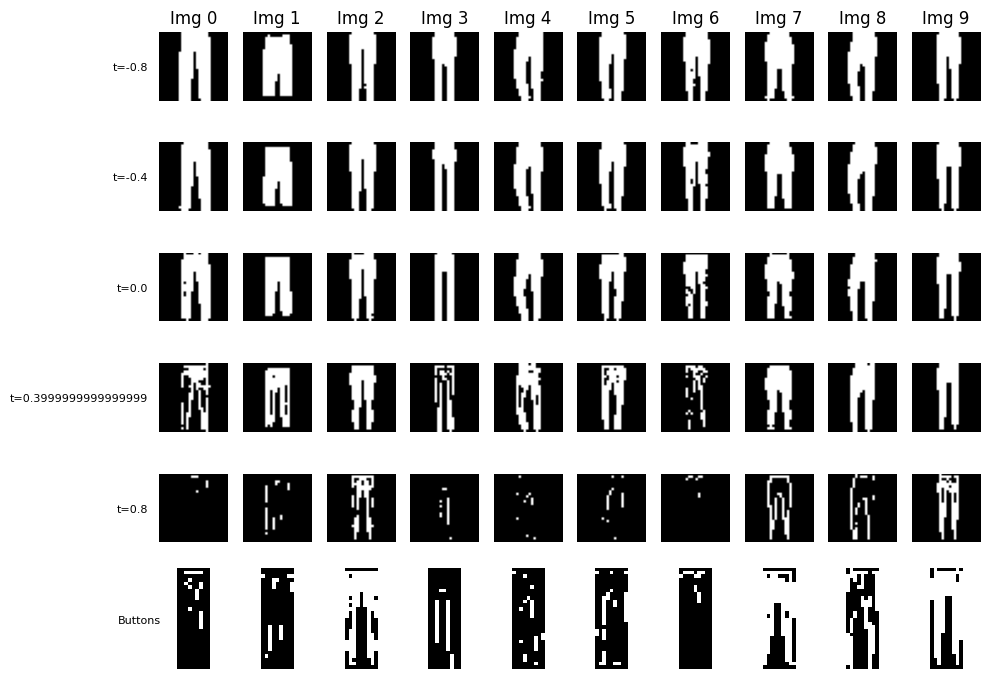

In [8]:
my_patches = {
    'Buttons': (slice(None), slice(10, 19)),
    #'Collar':  (slice(0, 5), slice(7, 21))
}

plot_binarized_by_fixed_threshold(data=MNIST_train_data, thresholds= [0.1*2-1, 0.3*2 -1, 0.5*2-1, 0.7*2-1, 0.9*2-1], target_label=1, num_images= 10,
                                   patches= my_patches, patch_q=0.7)

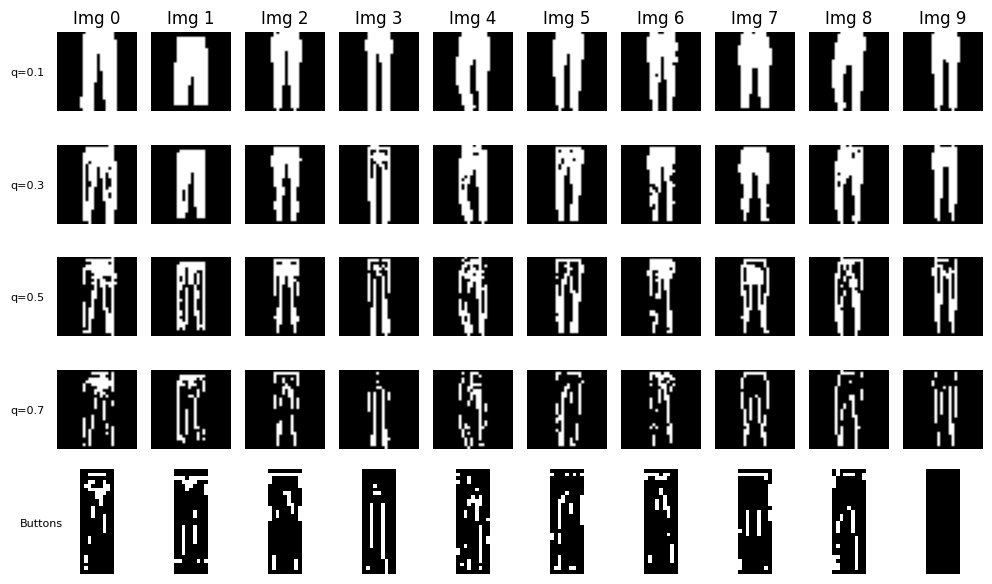

In [9]:
plot_binarized_by_quantile(data=MNIST_train_data, quantiles= [0.1, 0.3, 0.5, 0.7], target_label=1, num_images= 10,
                                   patches= my_patches, patch_q=0.8)

In [10]:
def _compute_safe_ect(binary_img, directions, num_thresholds, num_directions):
    """
    Safely computes the ECT for a binary image. 
    Returns a zero-vector if the image is empty or if the library fails.
    """
    if np.sum(binary_img) == 0:
        return np.zeros(num_directions * num_thresholds)

    try:
        seed = euler.CubicalComplex(binary_img).complexify()
        seed_coords = seed.cells[0]
        return seed.ECT(directions, T=num_thresholds, verts=seed_coords)
    except Exception:
        return np.zeros(num_directions * num_thresholds)

def _extract_patch(img, bounds):
    """
    Safely slices an image array using a bounds tuple (r_start, r_end, c_start, c_end).
    Handles 'None' values by defaulting to 0 or image dimensions.
    """
    if not bounds:
        return img
        
    r_start, r_end, c_start, c_end = bounds
    
    # Resolve None values to array boundaries
    r_start = r_start if r_start is not None else 0
    r_end = r_end if r_end is not None else img.shape[0]
    c_start = c_start if c_start is not None else 0
    c_end = c_end if c_end is not None else img.shape[1]
    
    return img[r_start:r_end, c_start:c_end]

def _get_adaptive_thresholds(img, quantiles):
    """Calculates specific threshold values based on non-zero pixel distribution."""
    non_zero_pixels = img[img > -0.99]
    if non_zero_pixels.size == 0:
        return [0.0] * len(quantiles)
    return np.quantile(non_zero_pixels, quantiles)

In [27]:
def process_single_item(data_item, quantiles, directions, num_directions, num_thresholds, patches=None, patch_q =0.7):
    img_gray_tensor, label = data_item
    img_gray = img_gray_tensor.numpy().squeeze()
    
    image_ect_vectors = []

    # 1. Get Thresholds
    thresholds = _get_adaptive_thresholds(img_gray, quantiles)
    
    # 2. Process Whole Image (Loop over all thresholds)
    for t_value in thresholds:
        img_binary = (img_gray > t_value).astype(int)
        
        ect_vec = _compute_safe_ect(
            img_binary, directions, num_thresholds, num_directions
        )
        image_ect_vectors.append(ect_vec)

    # 3. Process Patch (Only if bounds provided)
    if patches:
        for _, slice_obj in patches.items():
            img_patch = img_gray[slice_obj]
            #img_patch = _extract_patch(img_gray, patch_bound)
            non_zero_pixels = img_patch[img_patch> -0.99]
            t = np.quantile(non_zero_pixels, patch_q)
            img_patch_binary = (img_patch > t).astype(int)
            
            patch_ect_vec = _compute_safe_ect(
                img_patch_binary, directions, num_thresholds, num_directions
            )
            image_ect_vectors.append(patch_ect_vec)

    final_ect_vector = np.concatenate(image_ect_vectors)
    
    return final_ect_vector, label

In [28]:
def compute_ECT_parallel(data, quantiles, num_directions=50, num_thresholds=32, patches=None, patch_q = 0.8):
    directions = dirs.regular_directions(N=num_directions, dims=2)
    
    results = Parallel(n_jobs=-1, verbose=True)(
        delayed(process_single_item)(
            item, quantiles, directions, num_directions, num_thresholds, patches, patch_q
        ) for item in tqdm(data, desc="Extracting ECT Features (Parallel)")
    )
    
    X = [item[0] for item in results]
    y = [item[1] for item in results]
    
    return np.array(X), np.array(y), directions

In [13]:
def normalize_ect_components(data, num_components=3, epsilon=1e-8):
    """
    Splits the feature vector into `num_components` equal parts and 
    normalizes each part independently between 0 and 1.
    """
    n_samples, total_features = data.shape
    
    if total_features % num_components != 0:
        raise ValueError(f"Total features ({total_features}) not divisible by {num_components}")
        
    component_size = total_features // num_components
    
    # Reshape: (Batch, Components, Features_Per_Component)
    data_reshaped = data.reshape(n_samples, num_components, component_size)
    
    local_min = data_reshaped.min(axis=2, keepdims=True)
    local_max = data_reshaped.max(axis=2, keepdims=True)
    
    numerator = data_reshaped - local_min
    denominator = local_max - local_min + epsilon
    
    normalized_data = numerator / denominator
    
    return normalized_data.reshape(n_samples, total_features)



In [14]:
def plot_ect_matrices(data_norm, labels, samples_per_label=5, num_directions=50, num_thresholds=32, component_index=0):
    """
    Plots the ECT matrices for a specified component index, showing an equal 
    number of samples for each unique label in the provided labels array.
    
    Args:
        data_norm (np.ndarray): The normalized ECT data (N, 3 * Component_Size).
        labels (np.ndarray or list): The labels corresponding to the rows in data_norm.
        samples_per_label (int): The number of samples to plot for each unique label. (Default: 5)
        num_directions (int): The number of directions used in ECT computation.
        num_thresholds (int): The number of thresholds used in ECT computation.
        component_index (int): 0 for first component, 1 for second, etc.
    """
    # Convert labels to numpy array for efficient indexing
    labels = np.array(labels)
    
    # 1. Calculate the size of a single component vector
    matrix_rows = num_directions
    matrix_cols = num_thresholds
    component_size = matrix_rows * matrix_cols
    
    if data_norm.shape[1] % component_size != 0:
        print(f"Error: Feature size ({data_norm.shape[1]}) is not divisible by component size ({component_size}).")
        return
    
    start_col = component_index * component_size
    end_col = start_col + component_size
    
    # 2. Sample Data Indices
    unique_labels = np.unique(labels)
    plot_indices = []
    
    for label_val in unique_labels:
        label_indices = np.where(labels == label_val)[0] 
        selected_indices = label_indices[:samples_per_label]
        
        for idx in selected_indices:
            plot_indices.append((idx, label_val))

    # 3. Setup Plotting Grid
    num_plots = len(plot_indices)
    num_labels = len(unique_labels)
    
    # Use num_labels rows (for labels) and samples_per_label columns
    num_rows = num_labels
    num_cols = samples_per_label
    
    # Figure size scaled by the number of samples per label and total labels
    plt.figure(figsize=(num_cols * 3.5, num_rows * 3.5))
    plt.suptitle(f"ECT Matrices (Component {component_index + 1}) - {samples_per_label} Samples per Label", fontsize=16)
    
    # 4. Loop and Plot
    for plot_i, (data_idx, label_val) in enumerate(plot_indices):
        
        # Calculate row/column index based on the sequential plot index
        row_idx = plot_i // num_cols
        col_idx = plot_i % num_cols
        
        ax = plt.subplot(num_rows, num_cols, plot_i + 1)
        
        # Extract the vector for the current sample index and component segment
        ect_vector = data_norm[data_idx, start_col:end_col]
        ect_matrix = ect_vector.reshape(matrix_rows, matrix_cols)
        
        # Plotting
        im = ax.imshow(ect_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
        
        ax.set_title(f"Label {label_val}")
        ax.set_xlabel("Thresholds")
        
        # Label the first column of each row with the label value
        if col_idx == 0:
            ax.set_ylabel("Directions\n(Label Group)", fontweight='bold')
        else:
            ax.set_ylabel("Directions")
            
    # Add a single colorbar
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
    cbar_ax = plt.gcf().add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax)
    
    plt.show()


In [9]:
quantiles = [0.1, 0.3, 0.5, 0.7]
num_dir = 32
num_th = 16

subset = [MNIST_train_data[i] for i in range(10000)]
X, y, directions = compute_ECT_parallel(subset, quantiles, num_dir, num_th)

Extracting ECT Features (Parallel): 100%|██████████| 10000/10000 [01:52<00:00, 88.97it/s]
[Parallel(n_jobs=-1)]: Done 9969 out of 10000 | elapsed:  1.9min remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  1.9min finished


In [25]:
data_norm = normalize_ect_components(X, num_components=4)

print(f"Original range: {X.min():.2f} to {X.max():.2f}")
print(f"Normalized range: {data_norm.min():.2f} to {data_norm.max():.2f}")

Original range: -35.00 to 93.00
Normalized range: 0.00 to 1.00


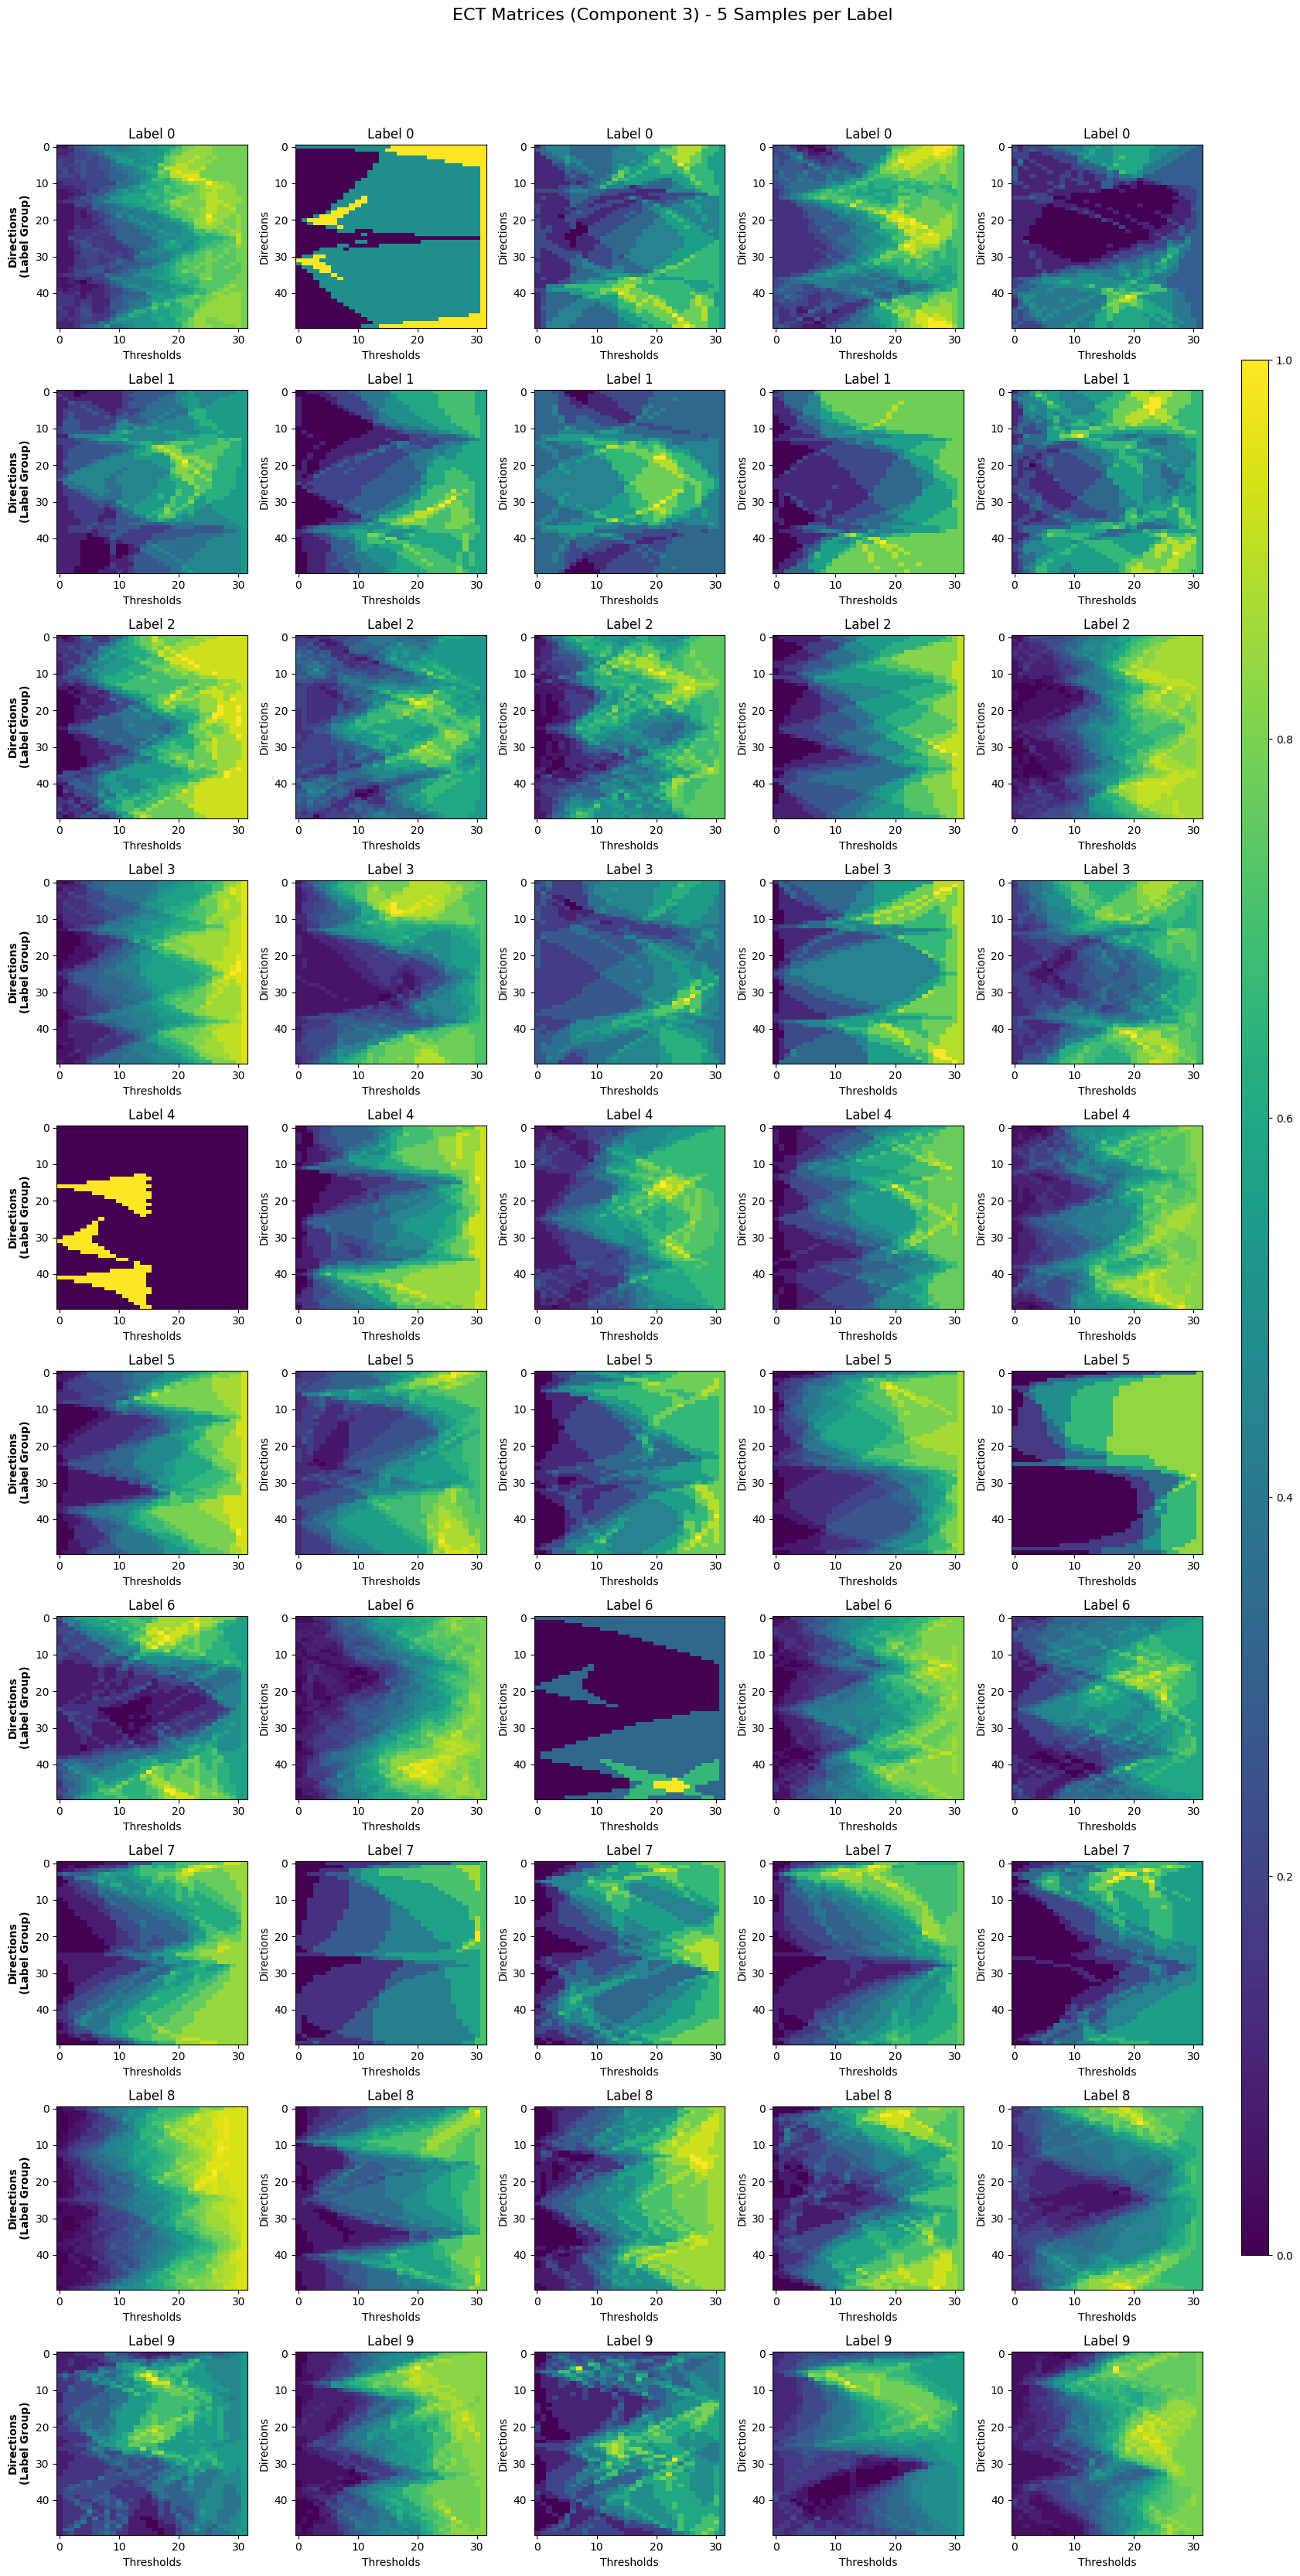

In [26]:
NUM_DIRECTIONS = 50
NUM_THRESHOLDS = 32

plot_ect_matrices(
    data_norm=data_norm, 
    labels=y,
    num_directions=NUM_DIRECTIONS, 
    num_thresholds=NUM_THRESHOLDS, 
    component_index=2
)

In [45]:
NUM_DIRECTIONS = 48
NUM_THRESHOLDS = 48
quantiles = [0.1, 0.3, 0.5, 0.7]
subset = [MNIST_train_data[i] for i in range(10000)]
my_patches = {
    'Buttons': (slice(None), slice(10, 19)),
    #'Collar':  (slice(0, 5), slice(7, 21))
}
X, y, directions = compute_ECT_parallel(MNIST_train_data, quantiles, NUM_DIRECTIONS, NUM_THRESHOLDS, my_patches)


# --- Log Parameters ---
logging.info(f"Parameters for SimpleECT_CNN run:")
logging.info(f"  Quantiles: {quantiles}")
logging.info(f"  Num Directions: {NUM_DIRECTIONS}")
logging.info(f"  Num Thresholds: {NUM_THRESHOLDS}")
# --- End Log ---

logging.info(f"Feature matrix X shape: {X.shape}")
# --- End Log ---

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train_ect, X_test_ect, y_train_ect, y_test_ect = train_test_split(
X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 11218 tasks      

In [46]:
logger.info("Starting TDA+RandomForest training...")
pipe_rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe_rf.fit(X_train_ect, y_train_ect)

logger.info("Evaluating RandomForest...")
y_pred_rf = pipe_rf.predict(X_test_ect)
acc_rf = accuracy_score(y_test_ect, y_pred_rf)
logger.info(f"TDA+RandomForest Accuracy: {100 * acc_rf:.2f} %")

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

report_rf = classification_report(y_test_ect, y_pred_rf, target_names=classes)
logger.info("Random Forest Classification Report:\n" + report_rf)

## CNN with ECT

In [ ]:
bins = len(quantiles)

class SimpleECT_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleECT_CNN, self).__init__()
        # First convolutional layer: takes bins input channel, produces 16 output channels
        self.conv1 = nn.Conv2d(in_channels=bins, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Second convolutional layer: takes 16 input channels, produces 32 output channels
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # We need to calculate the size of the flattened output after the conv/pool layers
        # Input: 50x32 -> After pool1: 25x16 -> After pool2: 12x8
        # So the flattened size is 32 * 12 * 8
        self.fc1 = nn.Linear(32 * (NUM_DIRECTIONS // 4) * (NUM_THRESHOLDS // 4), num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * (NUM_DIRECTIONS // 4) * (NUM_THRESHOLDS // 4))
        x = self.fc1(x)
        return x

In [49]:
bins = len(quantiles)+1
X_train_reshaped = X_train_ect.reshape(-1, bins, NUM_DIRECTIONS, NUM_THRESHOLDS)
X_test_reshaped = X_test_ect.reshape(-1, bins, NUM_DIRECTIONS, NUM_THRESHOLDS)

print(f"Original X_train shape: {X_train_ect.shape}")
print(f"Reshaped X_train shape: {X_train_reshaped.shape}")

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_ect, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_ect, dtype=torch.long)

# --- Create TensorDatasets and DataLoaders ---
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Original X_train shape: (48000, 11520)
Reshaped X_train shape: (48000, 5, 48, 48)


In [50]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
model = SimpleECT_CNN(num_classes=len(classes)).to(device)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Log Training Params ---
logging.info(f"  Num Epochs: {num_epochs}")
logging.info(f"  Learning Rate: 0.001")
logging.info("Starting SimpleECT_CNN training...")
# --- End Log ---

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the selected device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    logging.info(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    # --- End Log ---

print('Finished Training')
logging.info("Finished SimpleECT_CNN training.")

model.eval() # Set the model to evaluation mode
correct = 0
total = 0

# We don't need to calculate gradients during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get model outputs
        outputs = model(inputs)
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
# --- Capture, Print, and Log Accuracy ---
total_accuracy = 100 * correct / total
accuracy_str = f'\nAccuracy of the network on the {len(X_test_ect)} test images: {total_accuracy:.2f} %'
print(accuracy_str)
logging.info(f"Overall Test Accuracy: {total_accuracy:.2f} %")
# --- End Log ---

Using device: cpu
Epoch [1/50], Loss: 0.7417
Epoch [2/50], Loss: 0.4086
Epoch [3/50], Loss: 0.3472
Epoch [4/50], Loss: 0.3157
Epoch [5/50], Loss: 0.2893
Epoch [6/50], Loss: 0.2688
Epoch [7/50], Loss: 0.2509
Epoch [8/50], Loss: 0.2390
Epoch [9/50], Loss: 0.2215
Epoch [10/50], Loss: 0.2093
Epoch [11/50], Loss: 0.2002
Epoch [12/50], Loss: 0.1866
Epoch [13/50], Loss: 0.1753
Epoch [14/50], Loss: 0.1689
Epoch [15/50], Loss: 0.1581
Epoch [16/50], Loss: 0.1453
Epoch [17/50], Loss: 0.1380
Epoch [18/50], Loss: 0.1337
Epoch [19/50], Loss: 0.1255
Epoch [20/50], Loss: 0.1149
Epoch [21/50], Loss: 0.1165
Epoch [22/50], Loss: 0.1077
Epoch [23/50], Loss: 0.1074
Epoch [24/50], Loss: 0.0977
Epoch [25/50], Loss: 0.0917
Epoch [26/50], Loss: 0.0862
Epoch [27/50], Loss: 0.0836
Epoch [28/50], Loss: 0.0745
Epoch [29/50], Loss: 0.0767
Epoch [30/50], Loss: 0.0744
Epoch [31/50], Loss: 0.0670
Epoch [32/50], Loss: 0.0626
Epoch [33/50], Loss: 0.0671
Epoch [34/50], Loss: 0.0643
Epoch [35/50], Loss: 0.0571
Epoch [36/5

In [51]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        # Handle batch size of 1 (edge case)
        if c.dim() == 0:
            label = labels[0].item()
            class_correct[label] += c.item()
            class_total[label] += 1
            continue

        # For batches > 1
        for i in range(labels.size(0)):
            label = labels[i].item()
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nAccuracy by class:")
# --- Capture and Log Class-wise Accuracy ---
class_accuracy_log = ["Accuracy by class:"]
for i in range(10):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        log_str = f'Accuracy of {classes[i]:<11}: {accuracy:.2f} %'
    else:
        log_str = f'Accuracy of {classes[i]:<11}: N/A (No samples)'
    
    print(log_str)
    class_accuracy_log.append(f"  {log_str}") # Add indentation for log file
    
logging.info("\n".join(class_accuracy_log))
logging.info("="*50 + "\n") # Add separator for end of run
# --- End Log ---


Accuracy by class:
Accuracy of T-shirt/top: 81.08 %
Accuracy of Trouser    : 98.00 %
Accuracy of Pullover   : 81.75 %
Accuracy of Dress      : 84.83 %
Accuracy of Coat       : 75.08 %
Accuracy of Sandal     : 97.42 %
Accuracy of Shirt      : 66.75 %
Accuracy of Sneaker    : 94.33 %
Accuracy of Bag        : 97.33 %
Accuracy of Ankle boot : 95.08 %


## Classification Based on Feature Matching

In [ ]:
x11 = X[1][:1600]
x12 = X[1][1601:3200]
x13 = X[1][3201:4800]
x14 = X[1][4801:6400]
x15 = X[1][6401:]

In [ ]:
def get_features(X, y, i, n):
    feature_vector = X[i]
    sample_label = y[i]
    segment_size = len(feature_vector) // n 
    
    computed_features = []

    for k in range(n):
        current_start = k * segment_size
        current_end = (k + 1) * segment_size
        
        segment = feature_vector[current_start:current_end]
        computed_features.append(segment)
        
    return computed_features, sample_label


In [ ]:
features2, y2 = get_features(X,y,2,5)
features1, y1  = get_features(X,y,1,5)

In [ ]:
np.corrcoef(features1[0], features2[0])

array([[1.        , 0.02223808],
       [0.02223808, 1.        ]])

In [ ]:
plt.imshow()

(0, 0)

3

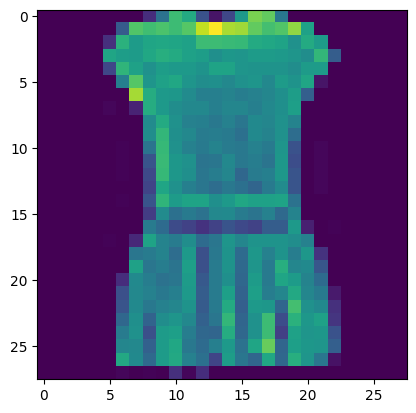

In [ ]:
img, label = MNIST_train_data[3]
plt.imshow(img.numpy().squeeze())
label


0

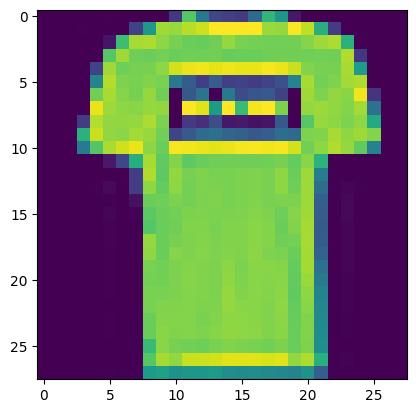

In [ ]:
img, label = MNIST_train_data[1]
plt.imshow(img.numpy().squeeze())
label

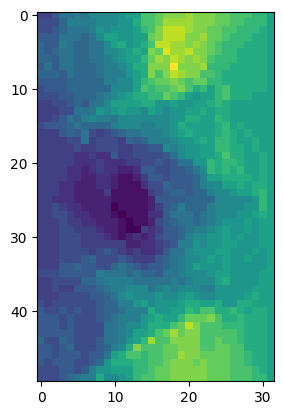

In [ ]:
plt.imshow(features1[2].reshape(50,32))

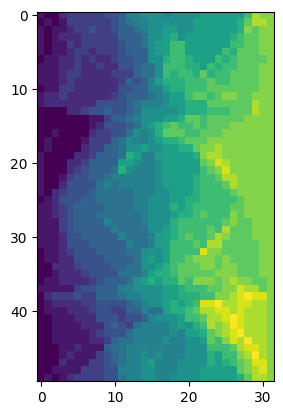

In [ ]:
plt.imshow(features2[2].reshape(50,32))